Imports e configurações

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

1) Parâmetros principais (AJUSTE O CAMINHO SE PRECISAR)

In [2]:
FILE_PATH = "synthetic_coffee_health_10000(in).csv"   # <- altere se o arquivo estiver em outro local

# Limites para evitar estouro de tempo com MUITOS gráficos
MAX_NUM_PLOTS = 8      # máximo de colunas numéricas para hist/box
MAX_CAT_PLOTS = 6      # máximo de colunas categóricas para barras/pizza
MAX_PIE_CATS  = 12     # desenha pizza só se tiver <= 12 categorias (para legibilidade)

# Sinônimos para tentativa de identificação automática das colunas de interesse
SYNONYMS = {
    "coffee": ["caffeine_mg", "coffee", "coffee_intake", "coffee_cups", "coffee_cups_per_day", "cafe", "café", "cups"],
    "sleep_hours": ["sleep_hours", "sleep_duration", "hours_of_sleep", "sleep"],
    "stress": ["stress_level", "stress"],
    "sleep_quality": ["sleep_quality", "sleep_score", "sleep_rating"]
}

 2) Funções utilitárias (robustas)

In [3]:
def carregar_dataset(path: str) -> pd.DataFrame:
    """
    Carrega CSV/Excel de forma resiliente, tentando ; como separador se necessário.
    """
    assert os.path.exists(path), f"Arquivo não encontrado: {path}"
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xls", ".xlsx"]:
        return pd.read_excel(path)
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, sep=";")

def guess_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    """
    Tenta mapear uma coluna por nome exato (case-insensitive) e depois por substring.
    """
    norm = {c.lower(): c for c in df.columns}
    for k in candidates:
        if k.lower() in norm:
            return norm[k.lower()]
    for c in df.columns:
        if any(k in c.lower() for k in candidates):
            return c
    return None

def to_numeric_ordinal(colname: str, s: pd.Series) -> pd.Series:
    """
    Converte séries para numérico:
      - se já for numérica: retorna como está;
      - tenta 'to_numeric', se >80% converter: usa;
      - tenta mapeamentos ordinais conhecidos (stress / sleep_quality);
      - fallback: codifica categorias (não preserva semântica).
    """
    if pd.api.types.is_numeric_dtype(s):
        return s
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().mean() > 0.80:
        return s_num

    vals = s.astype(str).str.strip().str.lower()
    name = colname.lower()

    # Ordens comuns para estresse
    if "stress" in name:
        orders = [
            ["very low","low","moderate","high","very high"],
            ["low","medium","high"],
            ["very low","low","below average","moderate","above average","high","very high"],
        ]
        for order in orders:
            if set(vals.unique()).issubset(set(order)) or set(order).issubset(set(vals.unique())):
                return vals.map({lab: i+1 for i, lab in enumerate(order)})

    # Ordens comuns para qualidade do sono
    if "sleep" in name and "quality" in name:
        orders = [
            ["very poor","poor","fair","good","very good","excellent"],
            ["poor","fair","good","very good","excellent"],
            ["1","2","3","4","5"]
        ]
        for order in orders:
            if set(vals.unique()).issubset(set(order)) or set(order).issubset(set(vals.unique())):
                return vals.map({lab: i+1 for i, lab in enumerate(order)})

    # Fallback: códigos inteiros (não ordena semanticamente)
    return pd.Series(pd.Categorical(vals).codes + 1, index=s.index, name=s.name)

# ---------- Gráficos básicos (matplotlib puro) ----------
def plot_hist(series: pd.Series, title: str):
    plt.figure(figsize=(7,4.5))
    plt.hist(series.dropna().values, bins=30, alpha=0.9)
    plt.title(title)
    plt.xlabel(series.name); plt.ylabel("Frequência")
    plt.show()

def plot_box(series: pd.Series, title: str):
    plt.figure(figsize=(5,5))
    plt.boxplot(series.dropna().values, vert=True, showmeans=True)
    plt.title(title)
    plt.ylabel(series.name)
    plt.show()

def plot_bar(s: pd.Series, title: str, max_cats=20):
    vc = s.value_counts(dropna=False).head(max_cats)
    plt.figure(figsize=(8,4.5))
    plt.bar(range(len(vc.index)), vc.values)
    plt.xticks(range(len(vc.index)), [str(i) for i in vc.index], rotation=45, ha="right")
    plt.title(title); plt.ylabel("Frequência")
    plt.tight_layout(); plt.show()

def plot_pie(s: pd.Series, title: str, max_cats=12):
    vc = s.value_counts(dropna=False)
    if len(vc) <= max_cats:
        plt.figure(figsize=(6,6))
        plt.pie(vc.values, labels=[str(i) for i in vc.index], autopct='%1.1f%%', startangle=90)
        plt.title(title)
        plt.show()

def plot_heatmap(corr: pd.DataFrame, title: str):
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_scatter(df: pd.DataFrame, x: str, y: str, title: str):
    """
    Dispersão com Pearson/Spearman no título. Converte 'y' para ordinal se necessário.
    """
    X = pd.to_numeric(df[x], errors="coerce")
    Y = to_numeric_ordinal(y, df[y])
    sub = pd.DataFrame({x: X, y: Y}).dropna()
    if sub.empty:
        print(f"[AVISO] Sem dados para {x} vs {y}")
        return
    r_p = sub[x].corr(sub[y], method="pearson")
    r_s = sub[x].corr(sub[y], method="spearman")
    plt.figure(figsize=(6.5,5))
    plt.scatter(sub[x], sub[y], alpha=0.7)
    plt.title(f"{title}\nPearson={r_p:.3f} | Spearman={r_s:.3f}")
    plt.xlabel(x); plt.ylabel(y)
    plt.tight_layout(); plt.show()

def iqr_outliers(series: pd.Series):
    """
    Conta outliers pelo critério IQR (1,5 * IQR).
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return 0, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    li, ls = q1 - 1.5*iqr, q3 + 1.5*iqr
    count = ((s < li) | (s > ls)).sum()
    return int(count), float(li), float(ls)

3) Carregamento + checagens de qualidade

In [4]:
print("== Carregando dataset ==")
df = carregar_dataset(FILE_PATH)

print("\nDimensões:", df.shape)
print("\nPrimeiras linhas:")
display(df.head())

print("\nTipos de dados:")
display(pd.DataFrame(df.dtypes, columns=["dtype"]).T)

print("\nNulos por coluna (contagem e %):")
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(2)
na_df = pd.DataFrame({"nulos": na_counts, "%": na_pct}).sort_values("nulos", ascending=False)
display(na_df)

dup_rows = df.duplicated().sum()
print(f"\nLinhas duplicadas: {dup_rows}")

== Carregando dataset ==

Dimensões: (10000, 16)

Primeiras linhas:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1



Tipos de dados:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
dtype,int64,int64,object,object,float64,float64,float64,object,float64,int64,object,float64,object,object,int64,int64



Nulos por coluna (contagem e %):


,nulos,%
Health_Issues,5941,59.41
ID,0,0.00
Gender,0,0.00
Age,0,0.00
Coffee_Intake,0,0.00
Caffeine_mg,0,0.00
Sleep_Hours,0,0.00
Country,0,0.00
Sleep_Quality,0,0.00
BMI,0,0.00



Linhas duplicadas: 0


4) Estatísticas descritivas iniciais

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\n== Estatísticas (numéricas) ==")
if num_cols:
    desc = df[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
    display(desc)

    # Assimetria e curtose ajudam a reconhecer caudas e pico de distribuição
    skew = df[num_cols].skew(numeric_only=True)
    kurt = df[num_cols].kurt(numeric_only=True)
    display(pd.DataFrame({"skew": skew, "kurtosis": kurt}).T)
else:
    print("Sem colunas numéricas detectadas.")

print("\n== Amostra de frequências (categóricas) ==")
for c in cat_cols[:10]:  # limita para não poluir
    print(f"\nTop categorias — {c}")
    display(df[c].value_counts(dropna=False).head(15))



== Estatísticas (numéricas) ==


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
ID,10000.0,5000.50000,2886.895680,1.0,100.99,500.95,2500.75,5000.5,7500.250,9500.050,9900.010,10000.0
Age,10000.0,34.94910,11.160939,18.0,18.00,18.00,26.00,34.0,43.000,54.000,62.010,80.0
Coffee_Intake,10000.0,2.50923,1.450248,0.0,0.00,0.00,1.50,2.5,3.500,5.000,6.100,8.2
Caffeine_mg,10000.0,238.41101,137.748815,0.0,0.00,0.00,138.75,235.4,332.025,474.005,578.603,780.3
Sleep_Hours,10000.0,6.63622,1.222055,3.0,3.80,4.60,5.80,6.6,7.500,8.600,9.500,10.0
BMI,10000.0,23.98686,3.906411,15.0,15.00,17.40,21.30,24.0,26.600,30.300,33.100,38.2
Heart_Rate,10000.0,70.61780,9.822951,50.0,50.00,54.00,64.00,71.0,77.000,87.000,93.000,109.0
Physical_Activity_Hours,10000.0,7.48704,4.315180,0.0,0.20,0.80,3.70,7.5,11.200,14.300,14.900,15.0
Smoking,10000.0,0.20040,0.400320,0.0,0.00,0.00,0.00,0.0,0.000,1.000,1.000,1.0
Alcohol_Consumption,10000.0,0.30070,0.458585,0.0,0.00,0.00,0.00,0.0,1.000,1.000,1.000,1.0


,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
skew,0.0,0.361852,0.263363,0.263181,-0.018317,0.047971,0.103866,0.003668,1.497103,0.869369
kurtosis,-1.2,-0.345720,-0.276540,-0.275741,-0.137749,-0.164905,-0.257489,-1.197604,0.241366,-1.244447



== Amostra de frequências (categóricas) ==

Top categorias — Gender


,count
Gender,
Female,5001
Male,4773
Other,226



Top categorias — Country


,count
Country,
Canada,543
India,524
Norway,523
China,521
UK,519
Sweden,513
South Korea,512
Finland,510
Italy,509



Top categorias — Sleep_Quality


,count
Sleep_Quality,
Good,5637
Fair,2050
Excellent,1352
Poor,961



Top categorias — Stress_Level


,count
Stress_Level,
Low,6989
Medium,2050
High,961



Top categorias — Health_Issues


,count
Health_Issues,
NaN,5941
Mild,3579
Moderate,463
Severe,17



Top categorias — Occupation


,count
Occupation,
Office,2073
Other,2038
Student,1968
Healthcare,1964
Service,1957


5) Distribuições — Numéricas (hist/box/outliers)


== Distribuições numéricas (histogramas e boxplots) ==

— ID


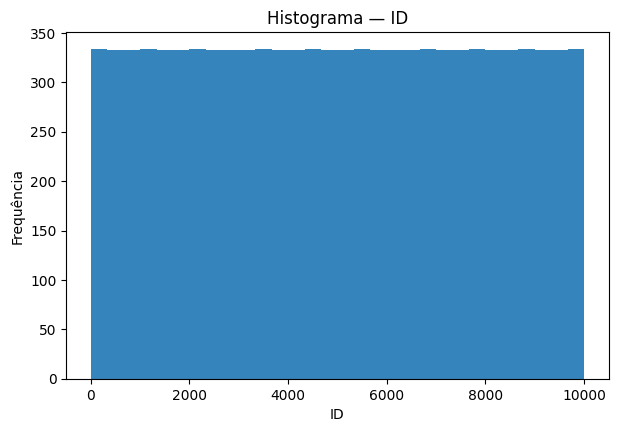

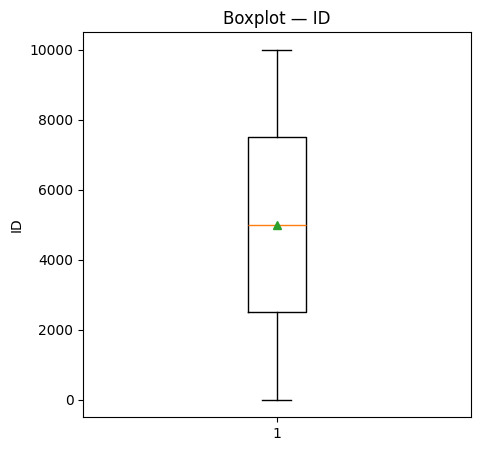

Outliers (IQR) em ID: 0 | Limites ≈ [-4998.500, 14999.500]

— Caffeine_mg


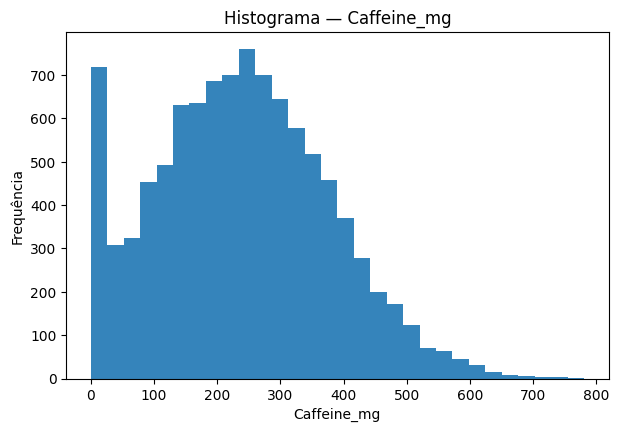

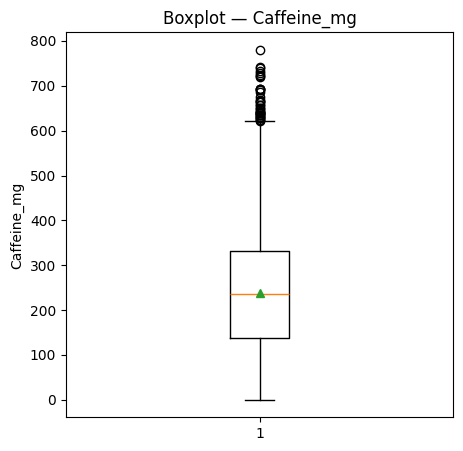

Outliers (IQR) em Caffeine_mg: 39 | Limites ≈ [-151.162, 621.938]

— Age


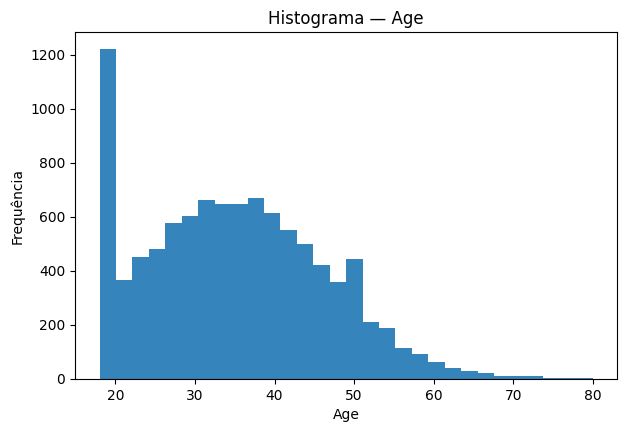

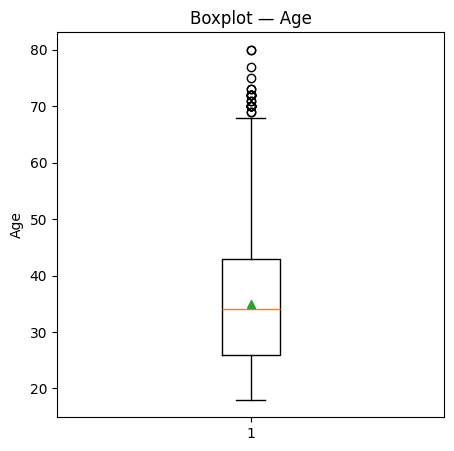

Outliers (IQR) em Age: 25 | Limites ≈ [0.500, 68.500]

— Heart_Rate


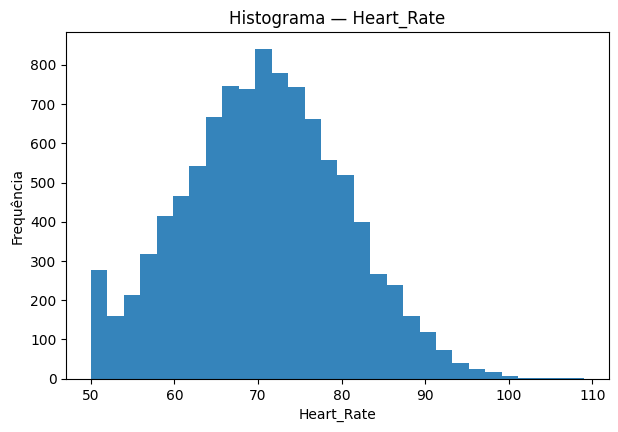

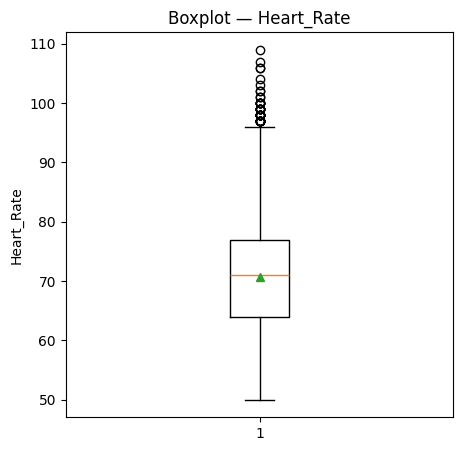

Outliers (IQR) em Heart_Rate: 50 | Limites ≈ [44.500, 96.500]

— Physical_Activity_Hours


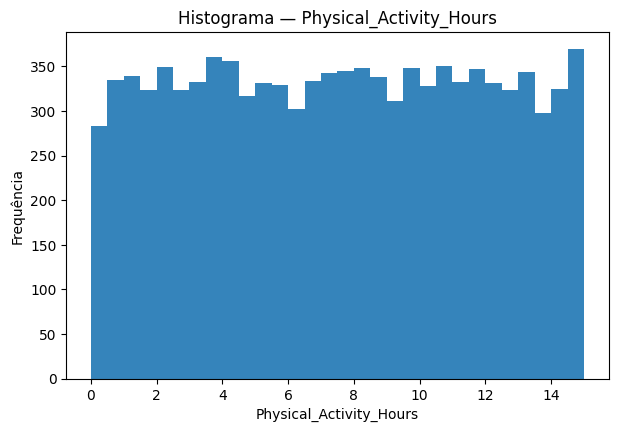

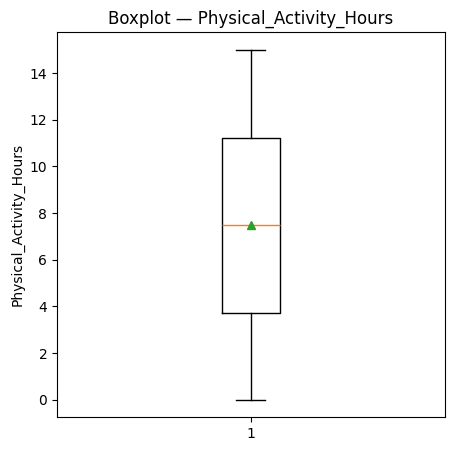

Outliers (IQR) em Physical_Activity_Hours: 0 | Limites ≈ [-7.550, 22.450]

— BMI


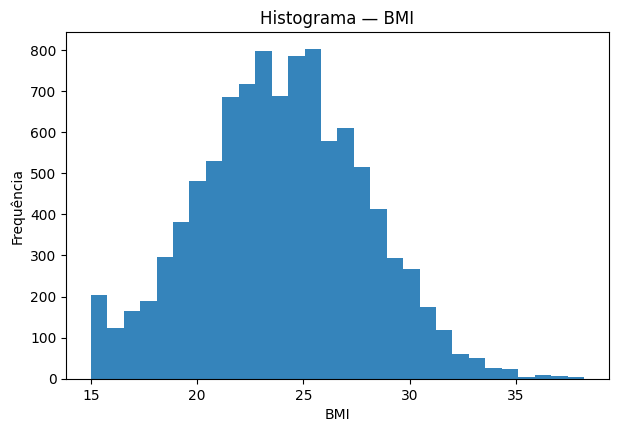

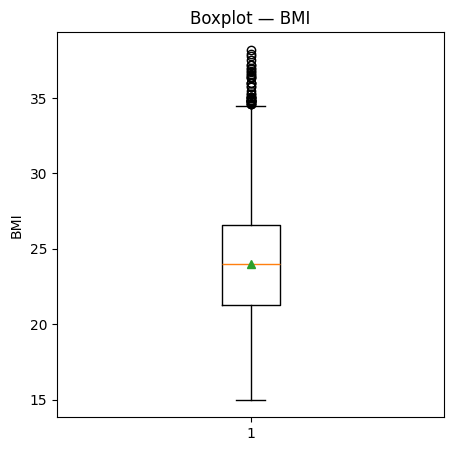

Outliers (IQR) em BMI: 40 | Limites ≈ [13.350, 34.550]

— Coffee_Intake


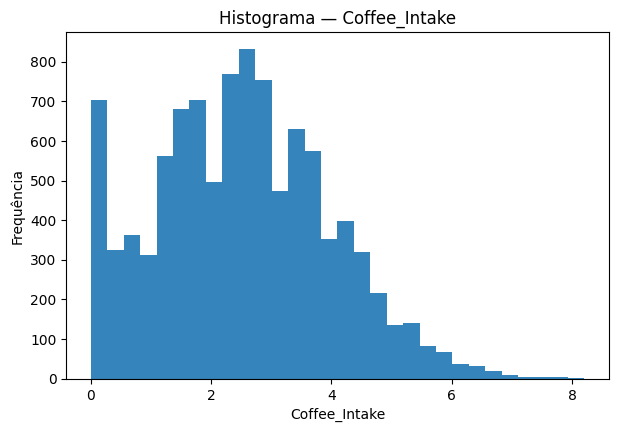

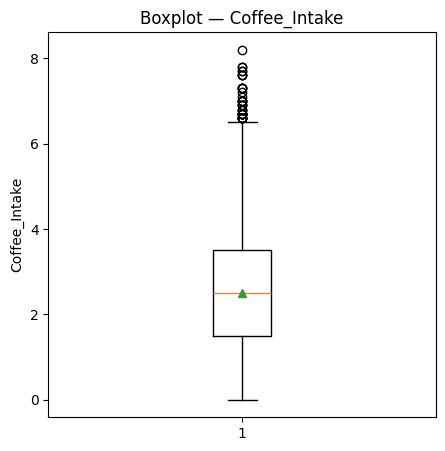

Outliers (IQR) em Coffee_Intake: 39 | Limites ≈ [-1.500, 6.500]

— Sleep_Hours


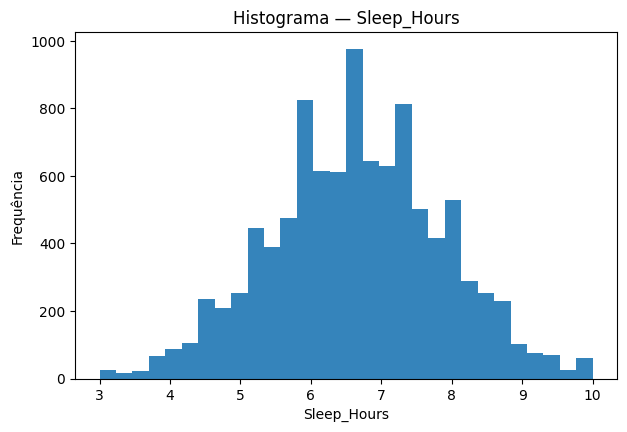

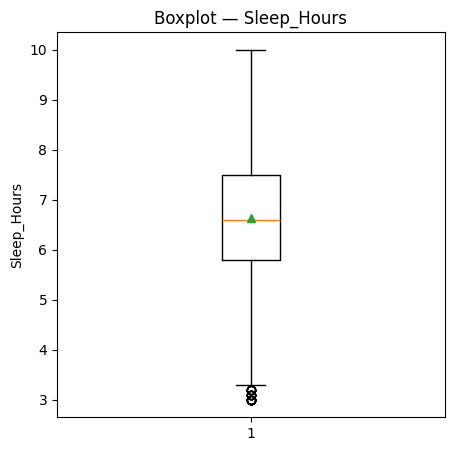

Outliers (IQR) em Sleep_Hours: 26 | Limites ≈ [3.250, 10.050]


In [6]:
if num_cols:
    # Seleciona até MAX_NUM_PLOTS colunas mais "representativas" (maior variância)
    var_order = df[num_cols].var(numeric_only=True).sort_values(ascending=False).index.tolist()
    chosen_num = var_order[:MAX_NUM_PLOTS]

    print("\n== Distribuições numéricas (histogramas e boxplots) ==")
    for col in chosen_num:
        print(f"\n— {col}")
        plot_hist(df[col], f"Histograma — {col}")
        plot_box(df[col], f"Boxplot — {col}")
        out_cnt, li, ls = iqr_outliers(df[col])
        print(f"Outliers (IQR) em {col}: {out_cnt} | Limites ≈ [{li:.3f}, {ls:.3f}]")
else:
    print("\nSem colunas numéricas para plotar.")

6) Distribuições — Categóricas (barras/pizza)


== Distribuições categóricas (barras e pizza) ==

— Gender


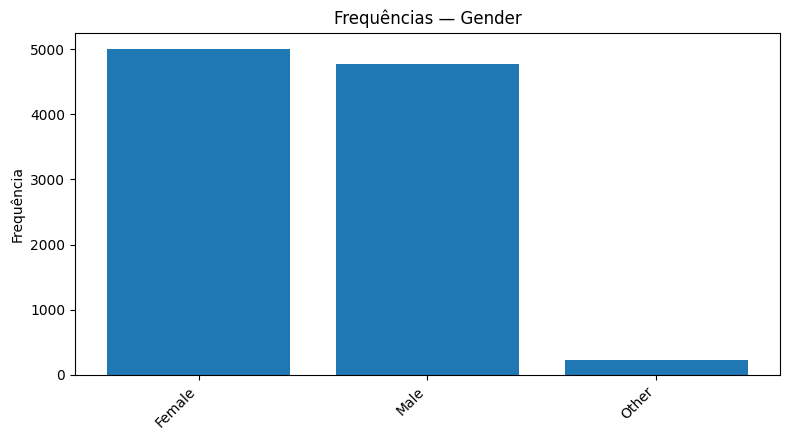

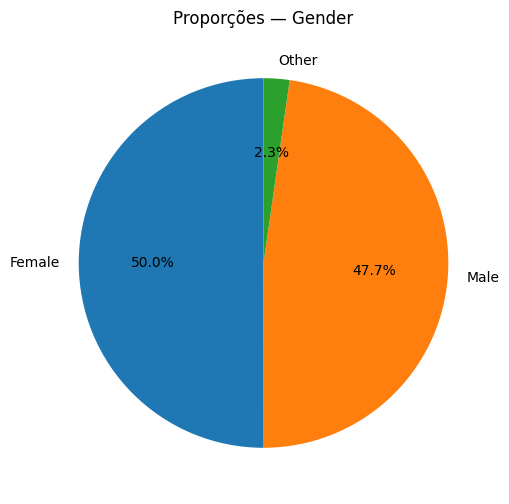


— Stress_Level


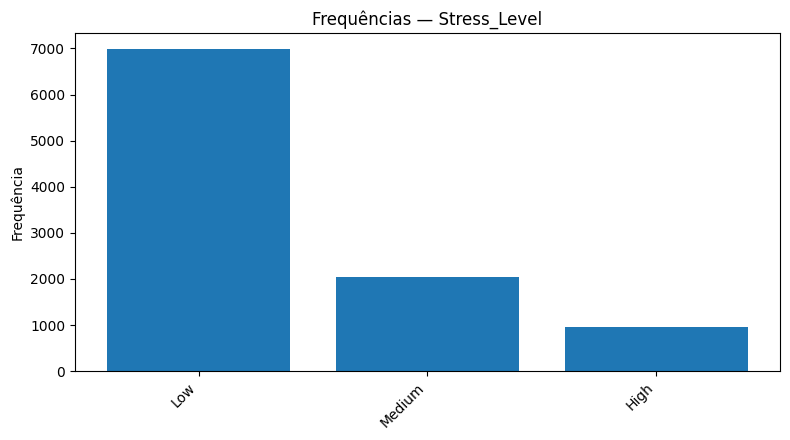

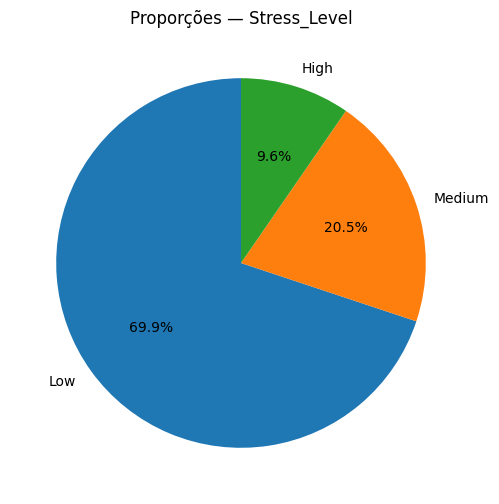


— Sleep_Quality


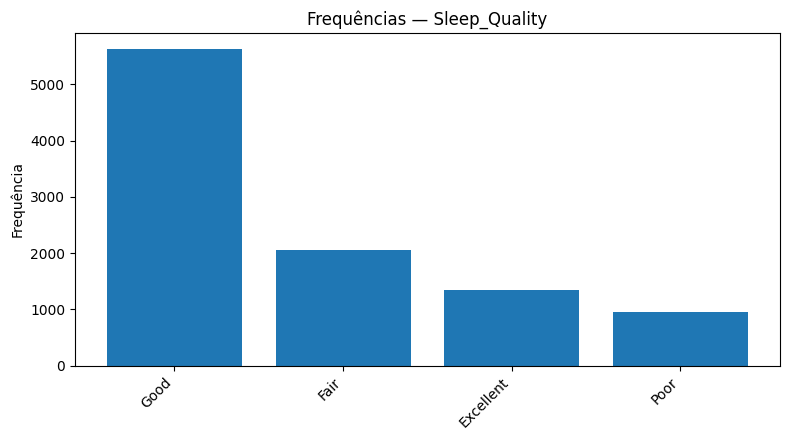

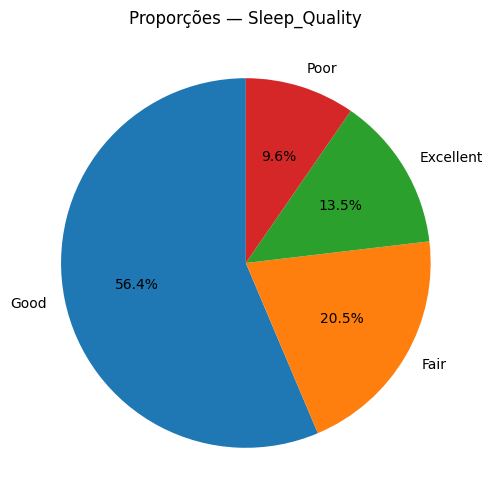


— Health_Issues


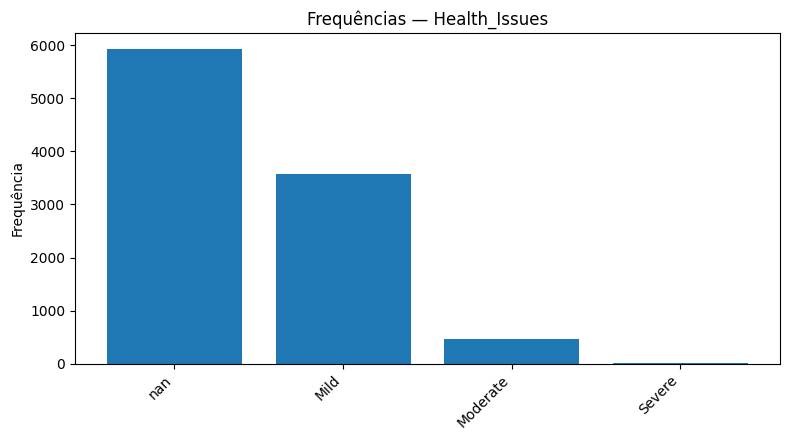

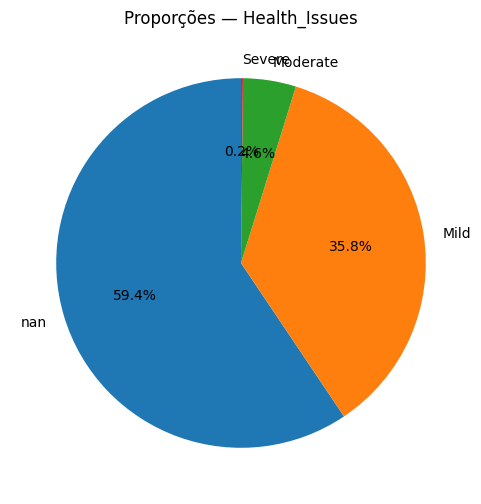


— Occupation


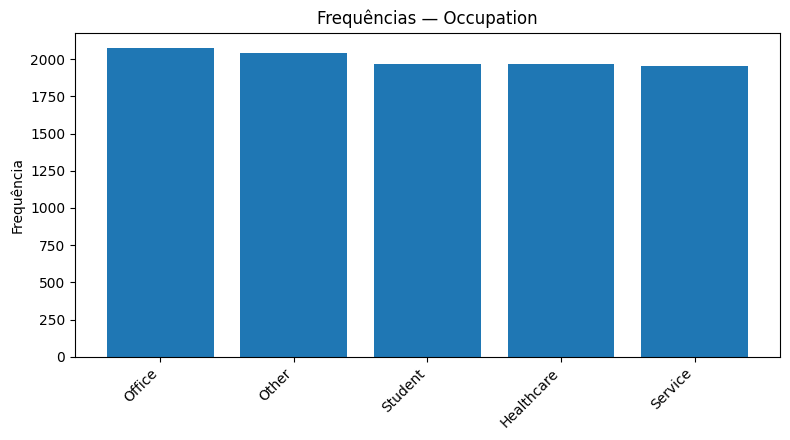

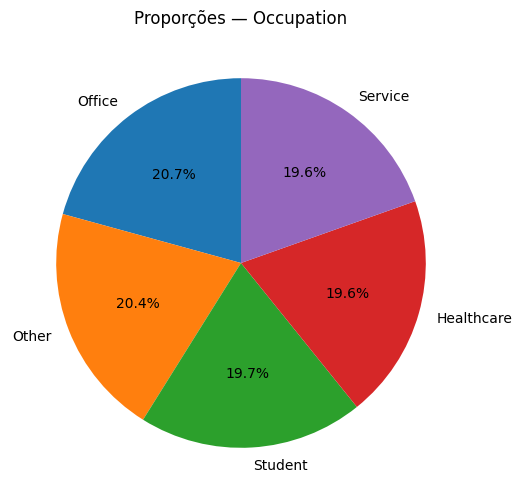


— Country


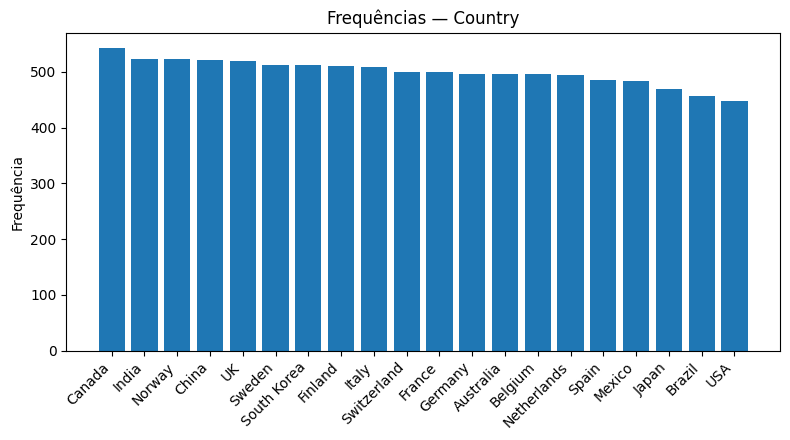

In [7]:
if cat_cols:
    # Prioriza categóricas com menor cardinalidade (mais legíveis)
    cat_sorted = sorted(cat_cols, key=lambda c: df[c].nunique(dropna=False))
    chosen_cat = cat_sorted[:MAX_CAT_PLOTS]

    print("\n== Distribuições categóricas (barras e pizza) ==")
    for col in chosen_cat:
        print(f"\n— {col}")
        plot_bar(df[col], f"Frequências — {col}", max_cats=20)
        plot_pie(df[col], f"Proporções — {col}", max_cats=MAX_PIE_CATS)
else:
    print("\nSem colunas categóricas para plotar.")

7) Correlações numéricas (heatmap + pares fortes)


== Correlação entre variáveis numéricas (Pearson) ==


,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
ID,1.000000,-0.008814,-0.005573,-0.005782,-0.010274,-0.010905,-0.002129,-0.007624,0.000291,-0.000143
Age,-0.008814,1.000000,-0.012155,-0.011797,0.005010,0.008627,-0.000197,0.005931,-0.013565,0.000998
Coffee_Intake,-0.005573,-0.012155,1.000000,0.999814,-0.190291,-0.008330,0.060123,0.004782,0.010836,-0.007798
Caffeine_mg,-0.005782,-0.011797,0.999814,1.000000,-0.190493,-0.008706,0.060027,0.005026,0.010829,-0.008018
Sleep_Hours,-0.010274,0.005010,-0.190291,-0.190493,1.000000,0.008463,-0.036219,-0.011228,0.007955,-0.003375
BMI,-0.010905,0.008627,-0.008330,-0.008706,0.008463,1.000000,-0.009362,0.002042,0.015319,-0.006537
Heart_Rate,-0.002129,-0.000197,0.060123,0.060027,-0.036219,-0.009362,1.000000,-0.002919,0.006534,-0.009474
Physical_Activity_Hours,-0.007624,0.005931,0.004782,0.005026,-0.011228,0.002042,-0.002919,1.000000,-0.007314,-0.019156
Smoking,0.000291,-0.013565,0.010836,0.010829,0.007955,0.015319,0.006534,-0.007314,1.000000,-0.011769
Alcohol_Consumption,-0.000143,0.000998,-0.007798,-0.008018,-0.003375,-0.006537,-0.009474,-0.019156,-0.011769,1.000000


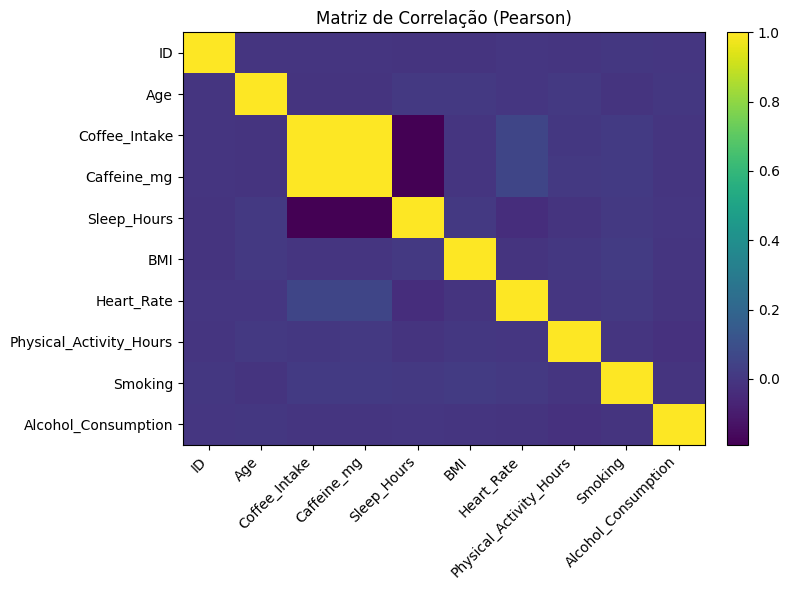


Pares com |correlação| ≥ 0.30:
  - Coffee_Intake ~ Caffeine_mg: r=1.000


In [8]:
if len(num_cols) >= 2:
    print("\n== Correlação entre variáveis numéricas (Pearson) ==")
    corr = df[num_cols].corr(method="pearson", numeric_only=True)
    display(corr)
    plot_heatmap(corr, "Matriz de Correlação (Pearson)")

    # Lista pares com |r| >= 0.30
    pares = []
    for a, b in combinations(num_cols, 2):
        r = corr.loc[a, b]
        if pd.notna(r) and abs(r) >= 0.30:
            pares.append((a, b, float(r)))
    pares.sort(key=lambda x: abs(x[2]), reverse=True)

    if pares:
        print("\nPares com |correlação| ≥ 0.30:")
        for a, b, v in pares[:20]:
            print(f"  - {a} ~ {b}: r={v:.3f}")
    else:
        print("\nNenhum par com |correlação| ≥ 0.30.")
else:
    print("\nCorrelação não calculada: menos de 2 colunas numéricas.")


8) Relações específicas — Café x Sono / Estresse / Qualidade do Sono


== Mapeamento automático das colunas de interesse ==
{'coffee': 'Caffeine_mg', 'sleep_hours': 'Sleep_Hours', 'stress': 'Stress_Level', 'sleep_quality': 'Sleep_Quality'}


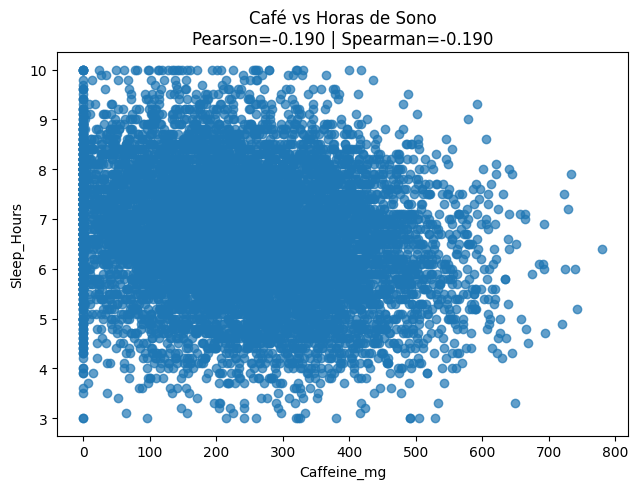

Correlação (Pearson) — Caffeine_mg vs Sleep_Hours: r=-0.190


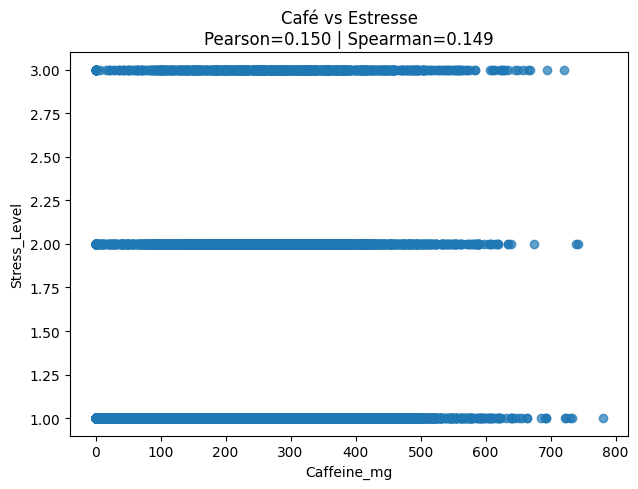

Correlação (Pearson) — Caffeine_mg vs Stress_Level: r=0.150


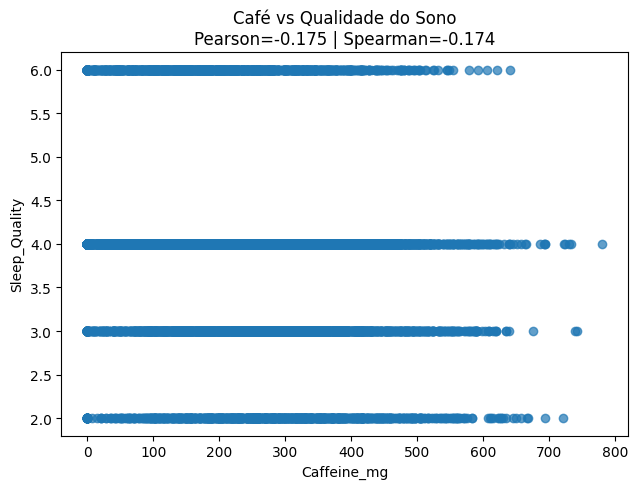

Correlação (Pearson) — Caffeine_mg vs Sleep_Quality: r=-0.175


In [9]:
coffee_col       = guess_col(df, SYNONYMS["coffee"])
sleep_hours_col  = guess_col(df, SYNONYMS["sleep_hours"])
stress_col       = guess_col(df, SYNONYMS["stress"])
sleep_quality_col= guess_col(df, SYNONYMS["sleep_quality"])

print("\n== Mapeamento automático das colunas de interesse ==")
print({
    "coffee": coffee_col,
    "sleep_hours": sleep_hours_col,
    "stress": stress_col,
    "sleep_quality": sleep_quality_col
})

# Dispersões + correlação pontual
def scatter_and_corr(x_col, y_col, titulo):
    if x_col is None or y_col is None:
        print(f"[INFO] Pular {titulo}: coluna não encontrada.")
        return
    # Dispersão com Pearson/Spearman
    plot_scatter(df, x_col, y_col, titulo)

    # Correlação numérica (convertendo y se necessário)
    X = pd.to_numeric(df[x_col], errors="coerce")
    Y = to_numeric_ordinal(y_col, df[y_col])
    sub = pd.DataFrame({"x": X, "y": Y}).dropna()
    if not sub.empty:
        r = sub["x"].corr(sub["y"], method="pearson")
        print(f"Correlação (Pearson) — {x_col} vs {y_col}: r={r:.3f}")

scatter_and_corr(coffee_col, sleep_hours_col,  "Café vs Horas de Sono")
scatter_and_corr(coffee_col, stress_col,       "Café vs Estresse")
scatter_and_corr(coffee_col, sleep_quality_col,"Café vs Qualidade do Sono")

9) Sumário textual rápido (achados principais)

In [10]:
print("\n== Sumário — Achados Iniciais ==")

# 9.1 Nulos
nz = na_df[na_df["nulos"] > 0]
if not nz.empty:
    print("\n• Colunas com nulos (top 10):")
    for col, row in nz.head(10).iterrows():
        print(f"  - {col}: {int(row['nulos'])} ({row['%']}%)")
else:
    print("\n• Não foram detectados valores nulos relevantes.")

# 9.2 Duplicados
print(f"• Linhas duplicadas: {dup_rows}")

# 9.3 Outliers por IQR (nas numéricas selecionadas)
if num_cols:
    print("\n• Colunas com mais outliers (entre as plotadas):")
    stats = []
    for c in (var_order[:MAX_NUM_PLOTS] if num_cols else []):
        cnt, li, ls = iqr_outliers(df[c])
        stats.append((c, cnt))
    for c, cnt in sorted(stats, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  - {c}: {cnt} outliers")

# 9.4 Correlações específicas (se colunas existirem)
def safe_corr(a_name, b_name, label):
    if a_name is None or b_name is None:
        return
    a = pd.to_numeric(df[a_name], errors="coerce")
    b = to_numeric_ordinal(b_name, df[b_name])
    sub = pd.DataFrame({"a": a, "b": b}).dropna()
    if sub.empty:
        return
    r = sub["a"].corr(sub["b"], method="pearson")
    print(f"• {label}: r={r:.3f}")

safe_corr(coffee_col, sleep_hours_col,  "Café vs Horas de Sono")
safe_corr(coffee_col, stress_col,       "Café vs Estresse")
safe_corr(coffee_col, sleep_quality_col,"Café vs Qualidade do Sono")

print("\n[Pronto] EDA concluída com sucesso.")


== Sumário — Achados Iniciais ==

• Colunas com nulos (top 10):
  - Health_Issues: 5941 (59.41%)
• Linhas duplicadas: 0

• Colunas com mais outliers (entre as plotadas):
  - Heart_Rate: 50 outliers
  - BMI: 40 outliers
  - Caffeine_mg: 39 outliers
  - Coffee_Intake: 39 outliers
  - Sleep_Hours: 26 outliers
  - Age: 25 outliers
  - ID: 0 outliers
  - Physical_Activity_Hours: 0 outliers
• Café vs Horas de Sono: r=-0.190
• Café vs Estresse: r=0.150
• Café vs Qualidade do Sono: r=-0.175

[Pronto] EDA concluída com sucesso.
